In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-08-04 07:48:05.394597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754318885.578658 2049646 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754318885.628452 2049646 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754318886.037005 2049646 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754318886.037027 2049646 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754318886.037030 2049646 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
import numpy as np
import os

def encode_voxel_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                        y_train_3d, y_val_3d, y_test_3d,
                        ref_d=None, save_dir='scalers'):
    """
    Encode a batch of 3D volumes by normalizing each depth slice independently and replicating to RGB.
    Each input of shape (N, 64, 64, 64) is transformed into (N*64, 64, 64, 3).

    Args:
        *_3d: ndarray of shape (N, 64, 64, 64)
        ref_d: optional ndarray of shape (64, 64, 64)
        save_dir: directory to save the (min, max) scalers for each batch

    Returns:
        Tuple of:
            x_train_rgb, x_val_rgb, x_test_rgb,
            y_train_rgb, y_val_rgb, y_test_rgb,
            ref_d_rgb (or None if not provided)
    """
    os.makedirs(save_dir, exist_ok=True)

    def process_batch(batch, tag):
        N, D, H, W = batch.shape  # (N, 64, 64, 64)
        rgb_batch = np.zeros((N * D, H, W, 3), dtype=np.float32)
        all_mins = []
        all_maxs = []

        for i in range(N):
            mins = []
            maxs = []
            for d in range(D):
                slice_2d = batch[i, d, :, :]
                s_min = float(slice_2d.min())
                s_max = float(slice_2d.max())

                if s_max == s_min:
                    s_max = s_min + 1e-6  # prevent divide-by-zero

                normed = (slice_2d - s_min) / (s_max - s_min)
                rgb = np.stack([normed] * 3, axis=-1)  # shape: (64, 64, 3)

                rgb_batch[i * D + d] = rgb
                mins.append(s_min)
                maxs.append(s_max)

            all_mins.append(mins)
            all_maxs.append(maxs)

        np.savez(os.path.join(save_dir, f'{tag}_scalers.npz'),
                 mins=np.array(all_mins), maxs=np.array(all_maxs))

        return rgb_batch

    x_train_rgb = process_batch(x_train_3d, 'x_train')
    x_val_rgb   = process_batch(x_val_3d, 'x_val')
    x_test_rgb  = process_batch(x_test_3d, 'x_test')
    y_train_rgb = process_batch(y_train_3d, 'y_train')
    y_val_rgb   = process_batch(y_val_3d, 'y_val')
    y_test_rgb  = process_batch(y_test_3d, 'y_test')

    # Optional: single ref volume
    ref_d_rgb = None
    if ref_d is not None:
        ref_rgb = np.zeros((64, 64, 64, 3), dtype=np.float32)
        ref_mins = []
        ref_maxs = []
        for d in range(64):
            slice_2d = ref_d[d, :, :]
            s_min = float(slice_2d.min())
            s_max = float(slice_2d.max())

            if s_max == s_min:
                s_max = s_min + 1e-6

            normed = (slice_2d - s_min) / (s_max - s_min)
            ref_rgb[d] = np.stack([normed] * 3, axis=-1)
            ref_mins.append(s_min)
            ref_maxs.append(s_max)

        np.savez(os.path.join(save_dir, 'ref_d_scalers.npz'),
                 mins=np.array(ref_mins), maxs=np.array(ref_maxs))
        ref_d_rgb = ref_rgb

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb
    )


In [ ]:
import numpy as np

def decode_rgb_to_voxel_batch(rgb_data, scaler_path):
    """
    Decode RGB-encoded batch (N*64, 64, 64, 3) back to original (N, 64, 64, 64) data
    using per-slice min/max scalers.

    Args:
        rgb_data: ndarray of shape (N*64, 64, 64, 3)
        scaler_path: path to `.npz` file containing 'mins' and 'maxs' arrays
                     of shape (N, 64)

    Returns:
        reconstructed: ndarray of shape (N, 64, 64, 64)
    """
    num_slices = 64
    assert rgb_data.ndim == 4 and rgb_data.shape[1:4] == (64, 64, 3), \
        f"Expected shape (N*64, 64, 64, 3), got {rgb_data.shape}"

    N = rgb_data.shape[0] // num_slices
    assert rgb_data.shape[0] == N * num_slices, "RGB data is not a multiple of 64 slices"

    scalers = np.load(scaler_path)
    mins = scalers['mins']  # shape (N, 64)
    maxs = scalers['maxs']  # shape (N, 64)

    reconstructed = np.zeros((N, 64, 64, 64), dtype=np.float32)

    for i in range(N):
        for d in range(num_slices):
            idx = i * num_slices + d
            normed = rgb_data[idx, :, :, 0]  # Use first channel (R), they are all the same
            s_min = mins[i, d]
            s_max = maxs[i, d]
            reconstructed[i, d, :, :] = normed * (s_max - s_min) + s_min

    return reconstructed


In [ ]:
x_train_rgb, x_val_rgb, x_test_rgb, \
y_train_rgb, y_val_rgb, y_test_rgb, \
ref_d_rgb = encode_voxel_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    ref_d=ref_d
)
print("done generating")

In [5]:
"""import os
save_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'
np.save(os.path.join(save_path, 'x_train_rgb_=3c.npy'), x_train_rgb)
np.save(os.path.join(save_path, 'x_val_rgb_=3c.npy'), x_val_rgb)
np.save(os.path.join(save_path, 'x_test_rgb_=3c.npy'), x_test_rgb)
np.save(os.path.join(save_path, 'y_train_rgb_=3c.npy'), y_train_rgb)
np.save(os.path.join(save_path, 'y_val_rgb_=3c.npy'), y_val_rgb)
np.save(os.path.join(save_path, 'y_test_rgb_=3c.npy'), y_test_rgb)
np.save(os.path.join(save_path, 'ref_d_rgb_=3c.npy'), ref_d_rgb)
import numpy as np"""

base_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'

x_train_rgb = np.load(f'{base_path}/x_train_rgb_=3c.npy')
x_val_rgb   = np.load(f'{base_path}/x_val_rgb_=3c.npy')
x_test_rgb  = np.load(f'{base_path}/x_test_rgb_=3c.npy')
y_train_rgb = np.load(f'{base_path}/y_train_rgb_=3c.npy')
y_val_rgb   = np.load(f'{base_path}/y_val_rgb_=3c.npy')
y_test_rgb  = np.load(f'{base_path}/y_test_rgb_=3c.npy')
ref_d_rgb   = np.load(f'{base_path}/ref_d_rgb_=3c.npy')
print("done")

done


I0000 00:00:1754319001.065471 2049646 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1754319001.068014 2049646 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1754319001.069595 2049646 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1754319001.071324 2049646 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/50


I0000 00:00:1754319006.441122 2051514 service.cc:152] XLA service 0x7f40d002c280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754319006.441145 2051514 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754319006.441150 2051514 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754319006.441152 2051514 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754319006.441154 2051514 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-04 07:50:06.538999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754319006.850018 2051514 cuda_dnn.cc:529] Loaded cuDNN version 90300


  38/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2156    

I0000 00:00:1754319010.098075 2051514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0701 - val_loss: 0.0437 - learning_rate: 1.0000e-04
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0423 - val_loss: 0.0412 - learning_rate: 1.0000e-04
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0403 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0391 - val_loss: 0.0388 - learning_rate: 1.0000e-04
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0386 - val_loss: 0.0383 - learning_rate: 1.0000e-04
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0381 - val_loss: 0.0380 - learning_rate: 1.0000e-04
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0377 - val_loss: 0.0377 - learning_rate: 1.0000e-04
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0374 - val_loss: 0.0375 - learning_rate: 1.0000e-04
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0372 - val_loss: 0

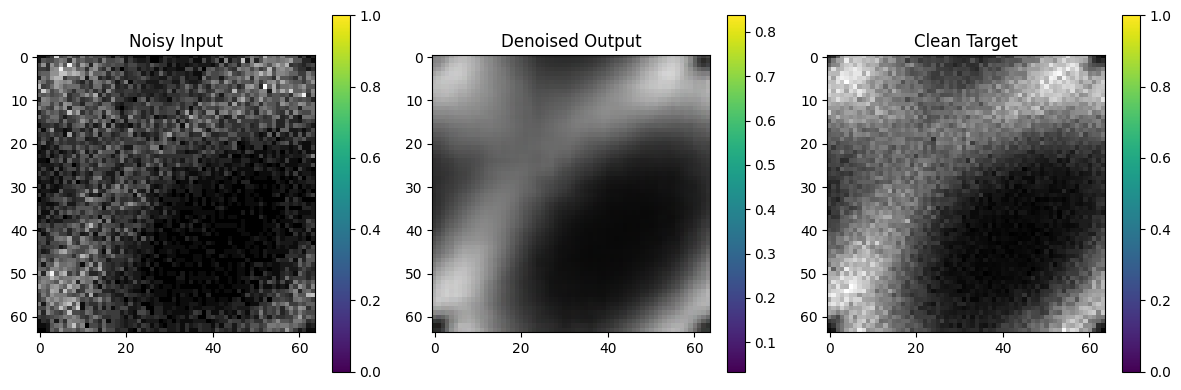

In [6]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt


def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
    print(total)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_2d_cae(input_shape=(64, 64, 3), dropout_rate=0.2, l2_strength=1e-8):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)


    output_layer =  layers.Conv2D(3, (3, 3),  activation='relu', padding='same')(x)

    #output_layer = layers.Lambda(renormalize_sum_to_eight)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)




# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)

    input_shape = (64, 64, 3)
    cae = create_simple_2d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train_rgb, y_train_rgb,
        validation_data=(x_val_rgb, y_val_rgb),
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test_rgb[i:i+1])[0]
    noisy_input = x_test_rgb[i]
    true_clean = y_test_rgb[i]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input)
    plt.title("Noisy Input")
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title("Denoised Output")
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(true_clean)
    plt.title("Clean Target")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()



In [11]:
cae.save("2d_CAE_IMG_enc.keras")
x_denoised = cae.predict(x_test_rgb[0:1])[0]  # Add batch, then squeeze

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


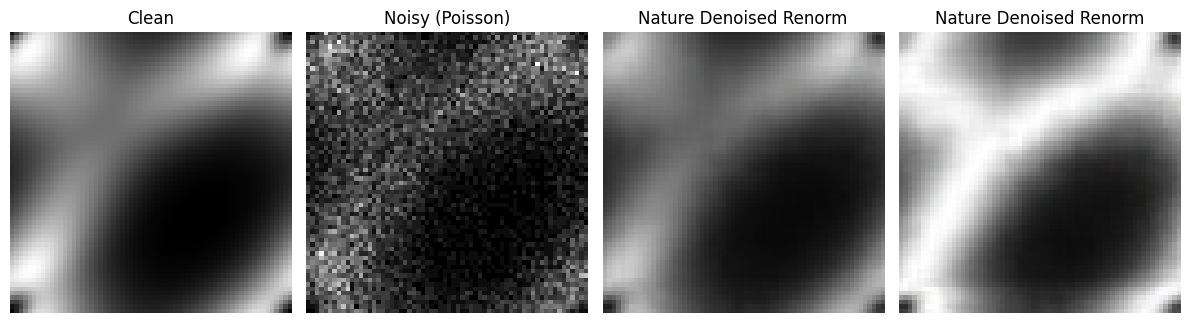

In [12]:


x_noisy = x_test_rgb[0]
x_clean = y_test_rgb[0]

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(ref_d_rgb[0])
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(x_noisy)
axs[1].set_title("Noisy (Poisson)")
axs[1].axis("off")


axs[2].imshow(x_denoised)
axs[2].set_title("Nature Denoised Renorm")
axs[2].axis("off")

def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * 1), 0, 1)

#might need to be renormalized because max is no longer 1
renorm_den = normalize_per_sample(x_denoised)
axs[3].imshow(renorm_den)
axs[3].set_title("Nature Denoised Renorm")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [13]:
print("Pixel sample (0,0):")
print("  Clean      :", x_clean[0,0])
print("  Noisy      :", x_noisy[0,0])
print("  Denoised   :", x_denoised[0,0])
print("  Renormed   :", renorm_den[0,0])

for label, img in zip(["Clean", "Noisy", "Denoised", "Renormed"],
                      [x_clean, x_noisy, np.clip(x_denoised, 0, 1), renorm_den]):
    print(f"{label:<10} max: {np.max(img):.4f}, sum: {np.sum(img):.2f}")


Pixel sample (0,0):
  Clean      : [0.125 0.125 0.125]
  Noisy      : [0.04761905 0.04761905 0.04761905]
  Denoised   : [0.49980527 0.49907362 0.5045988 ]
  Renormed   : [0.6568178 0.6558563 0.6631172]
Clean      max: 1.0000, sum: 4299.60
Noisy      max: 1.0000, sum: 2516.14
Denoised   max: 0.8368, sum: 4081.06
Renormed   max: 1.0000, sum: 6772.78


In [15]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [16]:
# --- Evaluation ---
print("\n>>> Evaluation Metrics on BM3D Denoised Image")

# 2-norm difference (before/after renorm)
norm_original = np.linalg.norm(x_denoised - x_clean)
norm_renormed = np.linalg.norm(renorm_den - x_clean)

print(f"2-norm (x_denoised vs ref_d_rgb): {norm_original:.4f}")
print(f"2-norm (renormalized vs ref_d_rgb): {norm_renormed:.4f}")

# Jensen-Shannon divergence setup
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

jsd_noisy = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_noisy, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_original = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_denoised, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_renormed = jensen_shannon_divergence_loss(tf.convert_to_tensor(renorm_den, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
print(f"JSD (x_noisy vs ref_d_rgb): {jsd_noisy.numpy():.6f}")
print(f"JSD (x_denoised vs ref_d_rgb): {jsd_original.numpy():.6f}")
print(f"JSD (renormalized vs ref_d_rgb): {jsd_renormed.numpy():.6f}")


>>> Evaluation Metrics on BM3D Denoised Image
2-norm (x_denoised vs ref_d_rgb): 6.9539
2-norm (renormalized vs ref_d_rgb): 28.7887
JSD (x_noisy vs ref_d_rgb): 0.041275
JSD (x_denoised vs ref_d_rgb): 0.004342
JSD (renormalized vs ref_d_rgb): 0.004342
